# Importación de librería

In [ ]:
try:
  from IPython import get_ipython
  get_ipython().magic('clear')
  get_ipython().magic('reset -f')
except:
  pass

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib.ticker as mticker

In [ ]:
#df_noisy = pd.read_csv("/content/DataExp_ELV_Agua_Etanol.csv")

# Objetivos:
• Comprender la importancia práctica de modelar con precisión los equilibrios binarios.

• Analizar críticamente datos experimentales con dispersiones significativas.

• Entrenar modelos de machine learning (ML) que aproximen el ELV y los compare contra un modelo termodinámico (UNIFAC).

# Lectura de dataset

In [ ]:
#Path
csv_path = "/content/DataExp_ELV_Agua_Etanol.csv"

df = pd.read_csv(csv_path)
display(df)

,x,T_K,curva
0,0.000000,373.607555,liquid
1,0.000000,372.972576,liquid
2,0.000000,373.758529,liquid
3,0.000000,374.633870,liquid
4,0.000000,372.876687,liquid
...,...,...,...
9195,0.999368,349.982562,vapor
9196,0.999368,353.049707,vapor
9197,0.999368,352.926421,vapor
9198,0.999368,349.024854,vapor


In [ ]:
print(df.columns)

Index(['x', 'T_K', 'curva'], dtype='object')


**x:** fracción molar de etanol.

**T (K):** temperatura en Kelvin.

**curva:** tipo de fase `liquid` o `vapor`.


# Exploración básica

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9200 entries, 0 to 9199
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       9200 non-null   float64
 1   T_K     9200 non-null   float64
 2   curva   9200 non-null   object 
dtypes: float64(2), object(1)
memory usage: 215.8+ KB


# Estadística descriptiva

In [ ]:
df.describe()

,x,T_K
count,9200.000000,9200.000000
mean,0.561608,355.406548
std,0.286038,5.632513
min,0.000000,347.537873
25%,0.351205,351.759513
50%,0.614058,353.261601
75%,0.773261,356.936736
max,0.999753,375.903238


In [ ]:
stats = df.groupby(['curva']).agg({
    'x':['mean', 'std', 'min', 'max'],
    'T_K':['mean', 'std', 'min', 'max']
})
stats

x                                  T_K                        \
            mean       std  min       max        mean       std         min   
curva                                                                         
liquid  0.487014  0.316526  0.0  0.999753  355.470119  5.626699  348.445999   
vapor   0.636202  0.228764  0.0  0.999368  355.342976  5.638216  347.537873   

                    
               max  
curva               
liquid  375.831010  
vapor   375.903238

**Observaciones:**
- Se evidencia la fase líquida tiene una media de x aprox de 0.487014
- Se evidencia la fase vapor tiene una media de x aprox de 0.636202
- Estas fracciones suman más de 1, lo que evidencia la problemática de medición mencionada.


## Pairplot

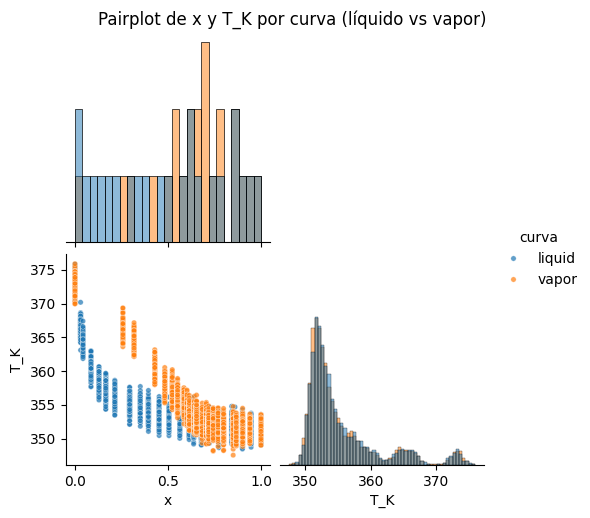

In [ ]:
g = sns.pairplot(
    data=df,
    vars=['x', 'T_K'],
    hue='curva',          # líquido vs vapor
    diag_kind='hist',
    corner=True,
    plot_kws=dict(s=15, alpha=0.7)
)
g.fig.suptitle("Pairplot de x y T_K por curva (líquido vs vapor)", y=1.02)
plt.show()

## Heatmap (Correlación)

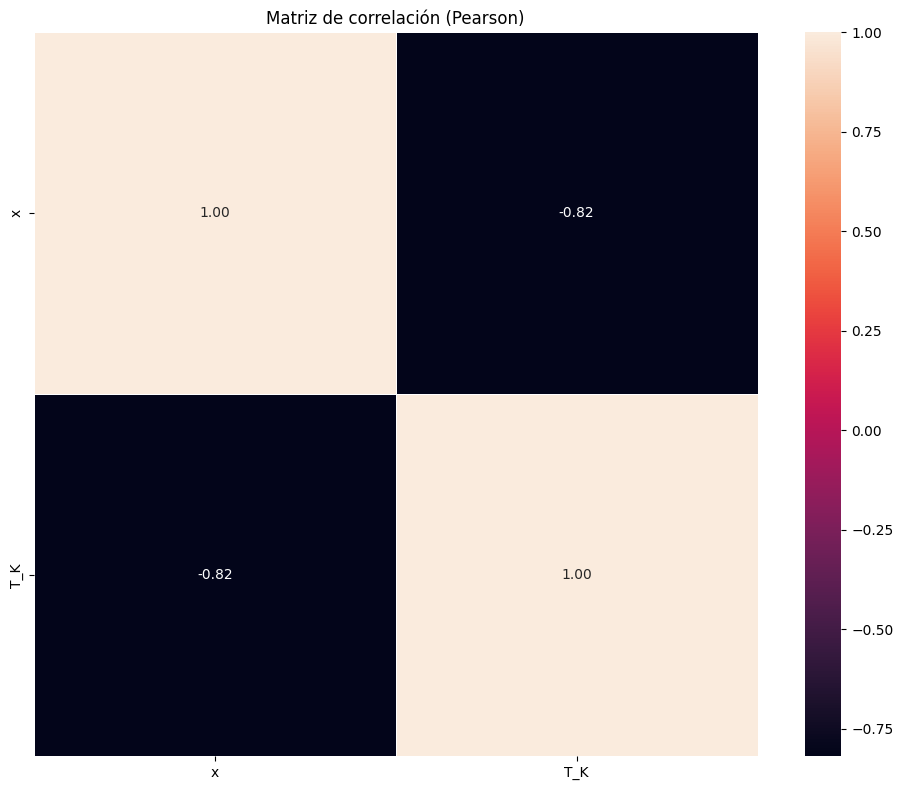

In [ ]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True, fmt=".2f",
    linewidths=0.5,
    square=True,
    cbar=True
)
plt.title("Matriz de correlación (Pearson)")
plt.tight_layout()
plt.show()

## Boxplot

/tmp/ipython-input-3940622701.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=90)


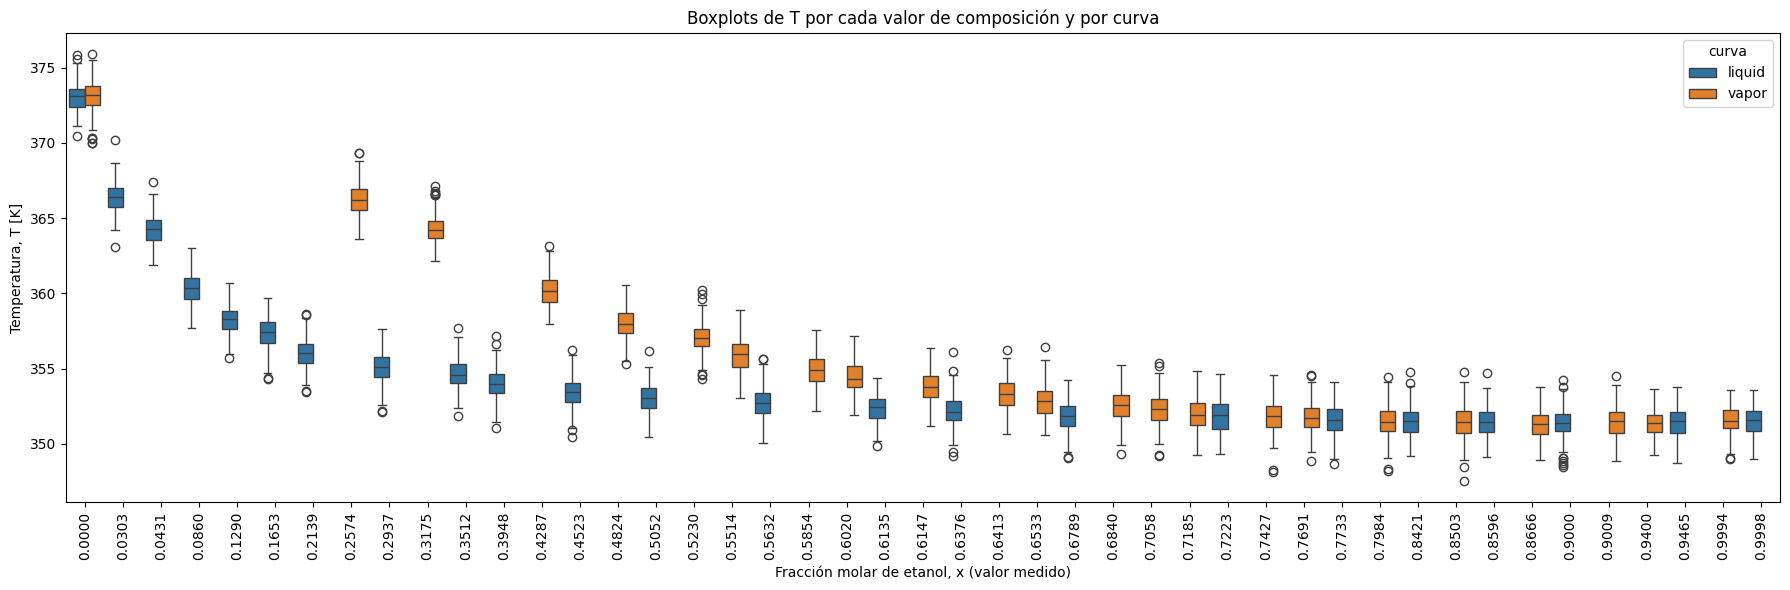

In [ ]:
df_sorted = df.sort_values('x').copy()
df_sorted['x_cat'] = df_sorted['x'].astype(str) #agrega una columna a df_sorted
plt.figure(figsize=(18, 6))

"""
Agregué el gráfico a una variable para usarlo en el for de abajo, ax = axis
El objeto reprsenta el gráfico
"""
ax =  sns.boxplot(
      data=df_sorted,
      x='x_cat',
      y='T_K',
      hue='curva'
  )

"""
ax.get_xticklabels() esto me da todas las etiquetas del eje X que está mostrando
y lo devuelve como una lista de objetos.

for t in ax.get_xticklabels() recorro toda la lista de objetos con el for

{float(t.get_text()):.4f} y esto convierte ese objeto de texto
extraído en flotante y muestra solo 4 decimales.
"""
#List comprehension
labels = [f"{float(t.get_text()):.4f}" for t in ax.get_xticklabels()]
ax.set_xticklabels(labels, rotation=90)


plt.xlabel('Fracción molar de etanol, x (valor medido)')
plt.ylabel('Temperatura, T [K]')
plt.title('Boxplots de T por cada valor de composición y por curva')
#plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

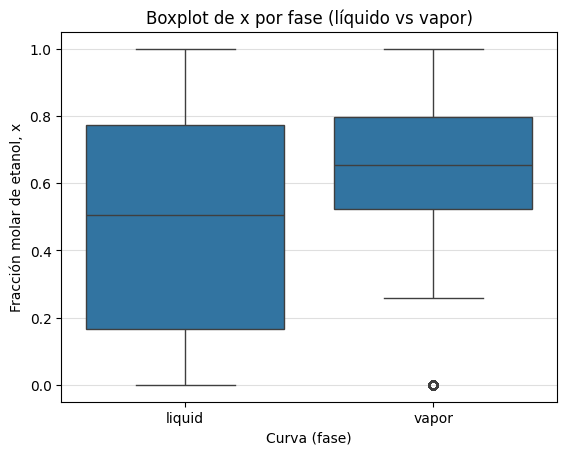

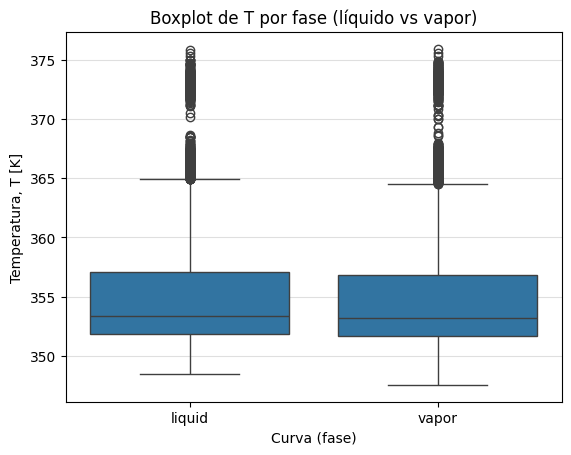

In [ ]:
plt.figure()
sns.boxplot(data=df, x='curva', y='x')
plt.xlabel('Curva (fase)')
plt.ylabel('Fracción molar de etanol, x')
plt.title('Boxplot de x por fase (líquido vs vapor)')
plt.grid(True, axis='y', alpha=0.4)
plt.show()

plt.figure()
sns.boxplot(data=df, x='curva', y='T_K')
plt.xlabel('Curva (fase)')
plt.ylabel('Temperatura, T [K]')
plt.title('Boxplot de T por fase (líquido vs vapor)')
plt.grid(True, axis='y', alpha=0.4)
plt.show()

El vapor es más rico en el componente más volátil (etanol) que el líquido en equilibrio.

El vapor en equilibrio es, en promedio, una corriente enriquecida en etanol respecto al líquido

## Histograms / distplots

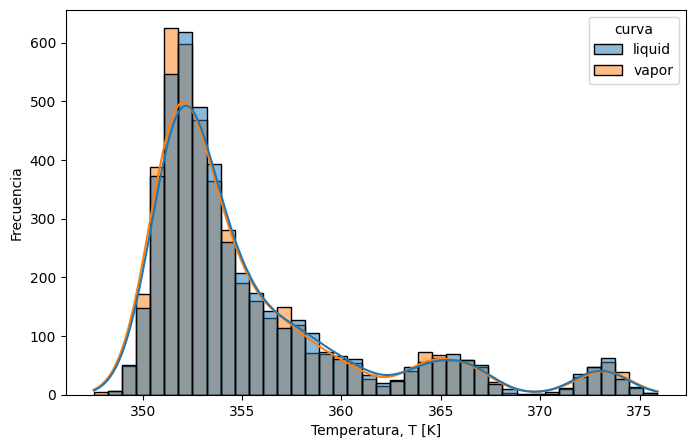

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(
    data=df,
    x='T_K',
    hue='curva',
    bins=40,
    kde=True,
    common_norm=False
)

plt.xlabel('Temperatura, T [K]')
plt.ylabel('Frecuencia')
plt.show()

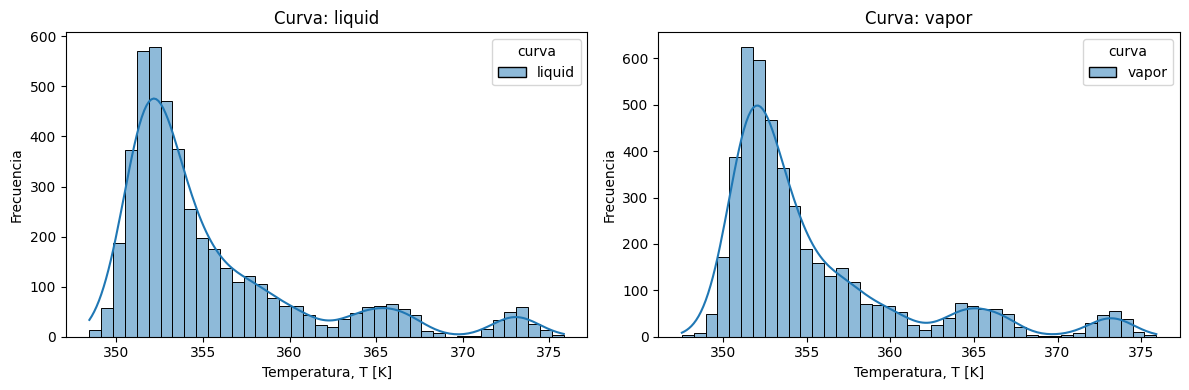

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

for ax, curve in zip(axes, ['liquid', 'vapor']):
  subset = df[df['curva'] == curve]
  sns.histplot(
      data=subset,
      x='T_K',
      hue='curva',
      kde='True',
      bins=40,
      ax=ax
      )
  ax.set_title(f'Curva: {curve}')
  ax.set_xlabel('Temperatura, T [K]')
  ax.set_ylabel('Frecuencia')


plt.tight_layout()
plt.show()

# Deteción de datos anómalos (IQR)

In [ ]:
df_noisy = df.copy()

In [ ]:
# Grupo por (x, curva)
g = df_noisy.groupby(["x", "curva"])["T_K"]

Q1 = g.quantile(0.25)
Q3 = g.quantile(0.75)
IQR = Q3 - Q1

#Usando el factor 0.05
lower = Q1 - 0.05 * IQR
upper = Q3 + 0.05 * IQR

stats = pd.concat(
    [
        Q1.rename("Q1"),
        Q3.rename("Q3"),
        IQR.rename("IQR"),
        lower.rename("lower"),
        upper.rename("upper"),
    ],
    axis=1,
)
stats

Q1          Q3       IQR       lower       upper
x        curva                                                           
0.000000 liquid  372.405713  373.611693  1.205980  372.345414  373.671992
         vapor   372.493670  373.803592  1.309922  372.428173  373.869088
0.030260 liquid  365.731742  367.024811  1.293069  365.667089  367.089464
0.043083 liquid  363.530227  364.896194  1.365967  363.461929  364.964492
0.086040 liquid  359.656763  361.048409  1.391646  359.587180  361.117991
0.129013 liquid  357.604402  358.853619  1.249217  357.541941  358.916080
0.165298 liquid  356.723565  358.101157  1.377592  356.654685  358.170036
0.213864 liquid  355.385875  356.617043  1.231168  355.324316  356.678601
0.257436 vapor   365.545032  366.911259  1.366227  365.476720  366.979570
0.293699 liquid  354.412446  355.757519  1.345073  354.345192  355.824773
0.317507 vapor   363.649442  364.788677  1.139235  363.592480  364.845639
0.351205 liquid  354.044751  355.291643  1.246891  353.982407  355.353987
0.394752 liquid  353.379085  354.659789  1.280704  353.315049  354.723824
0.428670 vapor   359.454742  360.883104  1.428361  359.383324  360.954522
0.452331 liquid  352.799972  354.054621  1.254650  352.737239  354.117354
0.482373 vapor   357.393090  358.679720  1.286630  357.328759  358.744052
0.505184 liquid  352.363362  353.708584  1.345222  352.296101  353.775845
0.522990 vapor   356.467739  357.595936  1.128196  356.411330  357.652345
0.551413 vapor   355.123508  356.642374  1.518866  355.047564  356.718317
0.563159 liquid  352.023820  353.365589  1.341770  351.956731  353.432678
0.585369 vapor   354.140317  355.632391  1.492074  354.065713  355.706995
0.602014 vapor   353.793847  355.177609  1.383762  353.724658  355.246797
0.613453 liquid  351.742185  352.993877  1.251692  351.679600  353.056462
0.614663 vapor   353.125794  354.474608  1.348814  353.058353  354.542049
0.637593 liquid  351.560337  352.850787  1.290450  351.495814  352.915310
0.641298 vapor   352.575387  354.018775  1.443388  352.503218  354.090944
0.653282 vapor   352.056191  353.516972  1.460781  351.983152  353.590011
0.678926 liquid  351.182789  352.488129  1.305340  351.117522  352.553396
0.684039 vapor   351.870066  353.246568  1.376502  351.801241  353.315393
0.705792 vapor   351.576164  352.999540  1.423376  351.504995  353.070709
0.718502 vapor   351.259443  352.702554  1.443111  351.187287  352.774709
0.722271 liquid  350.955553  352.657122  1.701569  350.870475  352.742201
0.742700 vapor   351.096815  352.539559  1.442744  351.024678  352.611696
0.769099 vapor   351.113621  352.405360  1.291739  351.049034  352.469947
0.773261 liquid  350.925765  352.298638  1.372873  350.857122  352.367282
0.798431 vapor   350.818782  352.151500  1.332718  350.752146  352.218136
0.842063 liquid  350.813441  352.088012  1.274570  350.749713  352.151740
0.850253 vapor   350.739046  352.174331  1.435285  350.667281  352.246095
0.859584 liquid  350.775301  352.096495  1.321194  350.709241  352.162555
0.866630 vapor   350.645647  351.914301  1.268653  350.582215  351.977733
0.899968 liquid  350.816515  351.972976  1.156461  350.758692  352.030799
0.900854 vapor   350.710070  352.138072  1.428002  350.638670  352.209472
0.939966 vapor   350.773779  351.926978  1.153199  350.716119  351.984638
0.946550 liquid  350.739997  352.096983  1.356985  350.672148  352.164832
0.999368 vapor   351.027367  352.216447  1.189080  350.967913  352.275901
0.999753 liquid  350.878587  352.205687  1.327100  350.812232  352.272042

`stats` tiene una fila por cada par (x, curva) con sus límites específicos (lower and upper)

In [ ]:

# Añadir límites a cada fila del df_noisy
df_noisy_iqr = df_noisy.join(stats, on=["x", "curva"])

# Flag de outlier
df_noisy_iqr["is_outlier"] = (
    (df_noisy_iqr["T_K"] < df_noisy_iqr["lower"]) |
    (df_noisy_iqr["T_K"] > df_noisy_iqr["upper"])
)

# Para el eje X más legible
df_noisy_iqr["x_cat"] = df_noisy_iqr["x"].round(3).astype(str)
df_noisy_iqr

,x,T_K,curva,Q1,Q3,IQR,lower,upper,is_outlier,x_cat
0,0.000000,373.607555,liquid,372.405713,373.611693,1.20598,372.345414,373.671992,False,0.0
1,0.000000,372.972576,liquid,372.405713,373.611693,1.20598,372.345414,373.671992,False,0.0
2,0.000000,373.758529,liquid,372.405713,373.611693,1.20598,372.345414,373.671992,True,0.0
3,0.000000,374.633870,liquid,372.405713,373.611693,1.20598,372.345414,373.671992,True,0.0
4,0.000000,372.876687,liquid,372.405713,373.611693,1.20598,372.345414,373.671992,False,0.0
...,...,...,...,...,...,...,...,...,...,...
9195,0.999368,349.982562,vapor,351.027367,352.216447,1.18908,350.967913,352.275901,True,0.999
9196,0.999368,353.049707,vapor,351.027367,352.216447,1.18908,350.967913,352.275901,True,0.999
9197,0.999368,352.926421,vapor,351.027367,352.216447,1.18908,350.967913,352.275901,True,0.999
9198,0.999368,349.024854,vapor,351.027367,352.216447,1.18908,350.967913,352.275901,True,0.999


## Limpieza de outliers

In [ ]:
# Datos marcados como outliers
df_clean = df_noisy_iqr[~df_noisy_iqr["is_outlier"]].copy()
display(df_clean)

,x,T_K,curva,Q1,Q3,IQR,lower,upper,is_outlier,x_cat
0,0.000000,373.607555,liquid,372.405713,373.611693,1.20598,372.345414,373.671992,False,0.0
1,0.000000,372.972576,liquid,372.405713,373.611693,1.20598,372.345414,373.671992,False,0.0
4,0.000000,372.876687,liquid,372.405713,373.611693,1.20598,372.345414,373.671992,False,0.0
5,0.000000,372.876703,liquid,372.405713,373.611693,1.20598,372.345414,373.671992,False,0.0
8,0.000000,372.641366,liquid,372.405713,373.611693,1.20598,372.345414,373.671992,False,0.0
...,...,...,...,...,...,...,...,...,...,...
9187,0.999368,351.904009,vapor,351.027367,352.216447,1.18908,350.967913,352.275901,False,0.999
9188,0.999368,351.423107,vapor,351.027367,352.216447,1.18908,350.967913,352.275901,False,0.999
9192,0.999368,352.130379,vapor,351.027367,352.216447,1.18908,350.967913,352.275901,False,0.999
9193,0.999368,351.858838,vapor,351.027367,352.216447,1.18908,350.967913,352.275901,False,0.999


### Número de filas iniciales y finales

In [ ]:
print("El total de filas iniciales era:", len(df_noisy), "filas")
print("El total de filas finales es:", len(df_clean), "filas")

removed = len(df_noisy) - len(df_clean)
print("Se eliminaron", removed, "filas")

El total de filas iniciales era: 9200 filas
El total de filas finales es: 4980 filas
Se eliminaron 4220 filas


### Porcentaje de datos eliminados para la curva de líquido y para la curva de vapor.

In [ ]:
"""
Aquí agrupamos igual que hicimos en la estadística descriptiva
usando .groupby() y .agg() para separar el dataframe en dos grupos
uno con todas las filas para líquido y otro con vapor.

outliers es un Booleano en el dataframe df_noisy_iqr, Pandas entiende eso
como 0 y 1.
"""
summary = (
    df_noisy_iqr.groupby("curva")["is_outlier"].agg(total="count", outliers="sum")
)

summary

,total,outliers
curva,,
liquid,4600,2114
vapor,4600,2106


In [ ]:
summary["% deleted"] = 100 * summary["outliers"] / summary["total"]
summary = summary.drop(columns=['pct_deleted'], errors='ignore')
summary

,total,outliers,% deleted
curva,,,
liquid,4600,2114,45.956522
vapor,4600,2106,45.782609


Conclusión:

Se eliminaron aproximadamente el 45.9% de los datos de la curva de líquido y el 45.7% de la curva de vapor como outliers según la regla del IQR con factor 0.05.

# Modelado del ELV con aprendizaje automático supervisado

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR

def build_models():
    models = []

    # Modelos lineales estándar
    models.append((
        "LinearRegression",
        Pipeline([
            ("scaler", StandardScaler()),
            ("reg", LinearRegression())
        ])
    ))

    models.append((
        "Ridge",
        Pipeline([
            ("scaler", StandardScaler()),
            ("reg", Ridge(alpha=1.0, random_state=42))
        ])
    ))

    models.append((
        "Lasso",
        Pipeline([
            ("scaler", StandardScaler()),
            ("reg", Lasso(alpha=1e-3, random_state=42, max_iter=10000))
        ])
    ))

    models.append((
        "ElasticNet",
        Pipeline([
            ("scaler", StandardScaler()),
            ("reg", ElasticNet(alpha=1e-3, l1_ratio=0.5, random_state=42, max_iter=10000))
        ])
    ))

    # Polinomiales suaves (2, 3 y 4)
    models.append((
        "PolyDeg2",
        Pipeline([
            ("poly", PolynomialFeatures(degree=2, include_bias=False)),
            ("scaler", StandardScaler()),
            ("reg", LinearRegression())
        ])
    ))

    models.append((
        "PolyDeg3",
        Pipeline([
            ("poly", PolynomialFeatures(degree=3, include_bias=False)),
            ("scaler", StandardScaler()),
            ("reg", LinearRegression())
        ])
    ))

    models.append((
        "PolyDeg4",
        Pipeline([
            ("poly", PolynomialFeatures(degree=4, include_bias=False)),
            ("scaler", StandardScaler()),
            ("reg", LinearRegression())
        ])
    ))

    # SVR con kernel RBF (tres configuraciones suaves)
    models.append((
        "SVR_RBF_C1",
        Pipeline([
            ("scaler", StandardScaler()),
            ("reg", SVR(kernel="rbf", C=1.0, epsilon=0.05))
        ])
    ))

    models.append((
        "SVR_RBF_C5",
        Pipeline([
            ("scaler", StandardScaler()),
            ("reg", SVR(kernel="rbf", C=5.0, epsilon=0.05))
        ])
    ))

    models.append((
        "SVR_RBF_C10",
        Pipeline([
            ("scaler", StandardScaler()),
            ("reg", SVR(kernel="rbf", C=10.0, epsilon=0.1))
        ])
    ))

    return models

In [ ]:
# Define X =x (fracción molar de etanol) y y = T_K.

# For the liquid curve
df_liquid = df_clean[df_clean["curva"] == "liquid"]
X_liquid = df_liquid["x"]
y_liquid = df_liquid["T_K"]

# For the vapor curve
df_vapor = df_clean[df_clean["curva"] == "vapor"]
X_vapor = df_vapor["x"]
y_vapor = df_vapor["T_K"]

In [ ]:
#Separa los datos
#- First split: 70% training, 30% temp (for validation + test)
#- Second split: 2/3 of temp → test (20% of total), 1/3 → validation (10% of total)



from sklearn.model_selection import train_test_split

# Liquid curve
X_liquid_train, X_liquid_temp, y_liquid_train, y_liquid_temp = train_test_split(
    X_liquid, y_liquid, test_size=0.30, random_state=42
)
X_liquid_val, X_liquid_test, y_liquid_val, y_liquid_test = train_test_split(
    X_liquid_temp, y_liquid_temp, test_size=2/3, random_state=42
)

# Vapor curve
X_vapor_train, X_vapor_temp, y_vapor_train, y_vapor_temp = train_test_split(
    X_vapor, y_vapor, test_size=0.30, random_state=42
)
X_vapor_val, X_vapor_test, y_vapor_val, y_vapor_test = train_test_split(
    X_vapor_temp, y_vapor_temp, test_size=2/3, random_state=42
)

In [ ]:
# Para cada modelo en build_models(), realiza validación cruzada con 5 folds sobre el conjunto de entrenamiento y reporta el RMSE promedio de CV.

from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# Reshape input if needed
# Convert Series to a 2D DataFrame for scikit-learn models
X_liquid_train = np.array(X_liquid_train).reshape(-1, 1)

y_liquid_train = y_liquid_train.ravel()


# Define RMSE scorer
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Get models
models = build_models()

# Evaluate each model
print("Average RMSE (5-fold CV) for liquid curve:")
for name, model in models:
    try:
        scores = cross_val_score(model, X_liquid_train, y_liquid_train,
                                 scoring="neg_root_mean_squared_error", cv=5)
        rmse_scores = -scores  # Convert negative scores to positive RMSE
        print(f"{name}: {np.mean(rmse_scores):.4f}")
    except Exception as e:
        print(f"{name}: ❌ Failed — {type(e).__name__}: {e}")


Average RMSE (5-fold CV) for liquid curve:
LinearRegression: 3.2628
Ridge: 3.2628
Lasso: 3.2628
ElasticNet: 3.2628
PolyDeg2: 2.0500
PolyDeg3: 1.4471
PolyDeg4: 0.9484
SVR_RBF_C1: 1.2140
SVR_RBF_C5: 0.8422
SVR_RBF_C10: 0.7101


Según los valores del RMSE, los modelos lineares (incluyendo Ridge, Lasso, ElasticNet) generan un subajuste, es decir un desempeño pobre. Los modelos polinomiales tienen mejor ajuste, pero hay riesgo de sobreajuste apartir del grado 4.
 Los modelos SVR con RBF kernel tienen el mejor desempeño de todos, especialmente con C=10.


In [ ]:
# Para cada modelo en build_models(), realiza validación cruzada con 5 folds sobre el conjunto de entrenamiento y reporta el RMSE promedio de CV

from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Ensure input is in the correct shape
X_liquid_train = np.array(X_liquid_train).reshape(-1, 1)
y_liquid_train = np.array(y_liquid_train).ravel()
X_liquid_val = np.array(X_liquid_val).reshape(-1, 1)
y_liquid_val = np.array(y_liquid_val).ravel()

# Get models
models = build_models()

# Evaluate each model on validation set
print("Validation performance (liquid curve):")
for name, model in models:
    try:
        model.fit(X_liquid_train, y_liquid_train)
        y_pred = model.predict(X_liquid_val)
        rmse = np.sqrt(mean_squared_error(y_liquid_val, y_pred))
        r2 = r2_score(y_liquid_val, y_pred)
        print(f"{name}: RMSE = {rmse:.4f}, R² = {r2:.4f}")
    except Exception as e:
        print(f"{name}: ❌ Failed — {type(e).__name__}: {e}")


Validation performance (liquid curve):
LinearRegression: RMSE = 3.0717, R² = 0.6722
Ridge: RMSE = 3.0716, R² = 0.6722
Lasso: RMSE = 3.0717, R² = 0.6722
ElasticNet: RMSE = 3.0716, R² = 0.6722
PolyDeg2: RMSE = 1.9619, R² = 0.8663
PolyDeg3: RMSE = 1.3953, R² = 0.9324
PolyDeg4: RMSE = 0.9637, R² = 0.9677
SVR_RBF_C1: RMSE = 1.0965, R² = 0.9582
SVR_RBF_C5: RMSE = 0.7691, R² = 0.9794
SVR_RBF_C10: RMSE = 0.6537, R² = 0.9852


In [ ]:
#Selecciona, para cada curva, el modelo con menor RMSE en validación. Reentrena ese modelo con el conjunto de entrenamiento+validación y evalúa su desempeño final  en el conjunto de prueba (RMSE y R2)


from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def evaluate_and_select_best_model(X_train, y_train, X_val, y_val, phase_name):
    models = build_models()
    best_model = None
    best_rmse = float("inf")
    best_name = ""

    print(f"\nValidation performance for {phase_name} curve:")
    for name, model in models:
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            rmse = np.sqrt(mean_squared_error(y_val, y_pred))
            r2 = r2_score(y_val, y_pred)
            print(f"{name}: RMSE = {rmse:.4f}, R² = {r2:.4f}")
            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model
                best_name = name
        except Exception as e:
            print(f"{name}: ❌ Failed — {type(e).__name__}: {e}")

    print(f"\n✅ Best model for {phase_name} curve: {best_name} (Validation RMSE = {best_rmse:.4f})")
    return best_model, best_name

def retrain_and_evaluate(model, X_trainval, y_trainval, X_test, y_test, phase_name):
    model.fit(X_trainval, y_trainval)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"\n📊 Final test performance for {phase_name} curve:")
    print(f"{model.named_steps['reg'].__class__.__name__}: RMSE = {rmse:.4f}, R² = {r2:.4f}")

# Ensure all arrays are NumPy and reshaped
def prepare_data(X, y):
    return np.array(X).reshape(-1, 1), np.array(y).ravel()

# Prepare data for both phases
X_liq_train, y_liq_train = prepare_data(X_liquid_train, y_liquid_train)
X_liq_val, y_liq_val = prepare_data(X_liquid_val, y_liquid_val)
X_liq_test, y_liq_test = prepare_data(X_liquid_test, y_liquid_test)

X_vap_train, y_vap_train = prepare_data(X_vapor_train, y_vapor_train)
X_vap_val, y_vap_val = prepare_data(X_vapor_val, y_vapor_val)
X_vap_test, y_vap_test = prepare_data(X_vapor_test, y_vapor_test)

# Liquid phase
best_liq_model, _ = evaluate_and_select_best_model(X_liq_train, y_liq_train, X_liq_val, y_liq_val, "liquid")
X_liq_trainval = np.vstack([X_liq_train, X_liq_val])
y_liq_trainval = np.concatenate([y_liq_train, y_liq_val])


Validation performance for liquid curve:
LinearRegression: RMSE = 3.0717, R² = 0.6722
Ridge: RMSE = 3.0716, R² = 0.6722
Lasso: RMSE = 3.0717, R² = 0.6722
ElasticNet: RMSE = 3.0716, R² = 0.6722
PolyDeg2: RMSE = 1.9619, R² = 0.8663
PolyDeg3: RMSE = 1.3953, R² = 0.9324
PolyDeg4: RMSE = 0.9637, R² = 0.9677
SVR_RBF_C1: RMSE = 1.0965, R² = 0.9582
SVR_RBF_C5: RMSE = 0.7691, R² = 0.9794
SVR_RBF_C10: RMSE = 0.6537, R² = 0.9852

✅ Best model for liquid curve: SVR_RBF_C10 (Validation RMSE = 0.6537)


 Predicción termodinámica con UNIFAC y comparación con ML

In [ ]:
# ================================================
# VLE Etanol-Agua con UNIFAC (thermo) + comparación ML
# ================================================
!pip install thermo --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import brentq

from thermo.unifac import UNIFAC, UFSG, UFIP # UNIFAC original

# ------------------------------------------------
# 1) Funciones de presión de vapor (Antoine) en kPa
# ------------------------------------------------
def Psat_water(T):
  """
  Agua, Antoine clásico (mmHg) convertido a kPa.
  Rango razonable: ~1100 °C
  """
  T_C = T - 273.15
  A, B, C = 8.07131, 1730.63, 233.426
  P_mmHg = 10**(A - B/(T_C + C))
  return P_mmHg*0.133322 # kPa

def Psat_ethanol(T):
  """
  Etanol, Antoine (mmHg) convertido a kPa.
  Rango razonable: ~1080 °C
  """
  T_C = T - 273.15
  A, B, C = 8.20417, 1642.89, 230.3
  P_mmHg = 10**(A - B/(T_C + C))
  return P_mmHg*0.133322 # kPa

P_total = 101.325 # kPa

# ------------------------------------------------
# 2) Definición de subgrupos UNIFAC
# Etanol: CH3 (1), CH2 (2), OH (14)
# Agua : H2O (16)
# ------------------------------------------------
chemgroups = [
    {1: 1, 2: 1, 14: 1}, # etanol
    {16: 1}, # agua
]

def bubble_T_UNIFAC(x1):
  """
  Calcula T de burbuja para fracción molar líquida x1 (etanol)
  buscando primero un intervalo [T_low, T_high] donde f(T) cambie de signo.
  """
  x2 = 1.0 - x1
  xs = [x1, x2]

  def f(T):
    GE = UNIFAC.from_subgroups(
        T=T,
        #Taller 1 6
        xs=xs,
        chemgroups=chemgroups,
        version=0,
        interaction_data=UFIP,
        subgroups=UFSG
    )
    gamma1, gamma2 = GE.gammas()
    P1 = Psat_ethanol(T)
    P2 = Psat_water(T)
    return x1*gamma1*P1 + x2*gamma2*P2 - P_total

  # 1) Buscar intervalo con cambio de signo
  T_candidates = np.linspace(340.0, 390.0, 200)
  f_vals = [f(T) for T in T_candidates]

  T_low, T_high = None, None
  for i in range(len(T_candidates)-1):
    if f_vals[i] == 0:
      return T_candidates[i]
    if f_vals[i]*f_vals[i+1] < 0:
      T_low = T_candidates[i]
      T_high = T_candidates[i+1]
      break

  if T_low is None:
    # No se encontró cambio de signo: devolver NaN para que luego lo filtres
    return np.nan

  # 2) Refinar la raíz con brentq
  return brentq(f, T_low, T_high)

# ------------------------------------------------
# 3) Curvas UNIFAC: bubble (líquido) y dew (vapor)
# ------------------------------------------------
xL_grid = np.linspace(0.001, 0.999, 50)
T_bubble = []
yE = []

for x1 in xL_grid:
  T = bubble_T_UNIFAC(x1)
  if np.isnan(T): # por seguridad, saltar si algo falló
    continue
  x2 = 1.0 - x1
  xs = [x1, x2]

  GE = UNIFAC.from_subgroups(
      T=T,
      xs=xs,
      chemgroups=chemgroups,
      version=0,
      interaction_data=UFIP,
      subgroups=UFSG
  )

  gamma1, gamma2 = GE.gammas()
  P1 = Psat_ethanol(T)
  P2 = Psat_water(T)
  y1 = x1*gamma1*P1 / P_total

  T_bubble.append(T)
  yE.append(y1)

df_unifac_liq = pd.DataFrame({"x": xL_grid[:len(T_bubble)], "T_K": T_bubble})
df_unifac_vap = pd.DataFrame({"x": yE, "T_K": T_bubble}).sort_values("x")

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df.columns[0], y=df_unifac_liq, data=df, color='blue', s=60, label='Datos Experimentales')

Evaluación cuantitativa: comparación UNIFAC vs ML

In [ ]:
!pip install python-docx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 17.1 MB/s eta 0:00:00


In [ ]:
from docx import Document

doc = Document()
doc.add_heading("My Colab Report", level=1)

# Example content
doc.add_paragraph("This is a summary of my model performance.")
doc.add_paragraph("SVR_RBF_C10 had the lowest RMSE on the validation set.")

# Save the file
doc.save("colab_output.docx")

In [ ]:
from google.colab import files
files.download("colab_output.docx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>